In [159]:
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

## Read the cycling network data

We make a map of the cycling networks.

In [160]:
filelist = []

for (root, directory, files) in os.walk("data/cycle_networks/"):
    for x in files:
        if x.endswith(".gpkg"):
            filelist.append(os.path.join(root,x))

df = gpd.GeoDataFrame()
for file in filelist:
    tmp = gpd.read_file(file)
    tmp= tmp.to_crs(epsg=4326)
    df = pd.concat([df,tmp])

In [161]:
cycle=df

## Read the infrastructure data

In [162]:
iww = gpd.read_file("data/TEN-T/iww_GL2017_EU_UK.shp")
railways = gpd.read_file("data/TEN-T/railways_GL2017_EU_UK.shp")
roads = gpd.read_file("data/TEN-T/roads_GL2017_EU_UK.shp")

# Convert coordination system
iww = iww.to_crs(epsg=4326)
railways=railways.to_crs(epsg=4326)
roads=roads.to_crs(epsg=4326)
  
# Select Benelux region
iww_benelux = iww.loc[iww["COUNTRY_CO"].isin(["BE","NL","LUX"])]
railways_benelux = railways.loc[railways["COUNTRY_CO"].isin(["BE","NL","LUX"])]
roads_benelux = roads.loc[roads["COUNTRY_CO"].isin(["BE","NL","LUX"])]

## Find the intersections

We calculate the intersections of the cycling network with the three types of infrastructure

In [163]:
i1 = iww_benelux.overlay(cycle,how="intersection",keep_geom_type=False)
i2 = railways_benelux.overlay(cycle,how="intersection",keep_geom_type=False)
i3 = roads_benelux.overlay(cycle,how="intersection",keep_geom_type=False)

all_crossings = pd.concat([i1,i2,i3])

## Get geodata

We get the geodata for Flanders region

In [164]:
data = gpd.read_file("./data/NUTS_regions/NUTS_RG_01M_2021_4326.geojson")
data= data.to_crs(epsg=4326)
data_BE=data.loc[data['CNTR_CODE']=='BE']
data_VL=data.loc[(data['CNTR_CODE']=='BE')&(data['NUTS_ID']=='BE2')]

## Limit crossings to Flanders

We select the crossings in flanders with the three types of infrastructure

In [165]:
ww_crossings = gpd.sjoin(i1, data_VL, op='within') # Waterway crossings with cycle routes
rr_crossings = gpd.sjoin(i2, data_VL, op='within') # Railroad crossings with cycle routes
hw_crossings = gpd.sjoin(i3, data_VL, op='within') # Highway crossings with cycle routes

c:\Users\Theranet\miniconda3\envs\aghack\Lib\site-packages\IPython\core\interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\Theranet\miniconda3\envs\aghack\Lib\site-packages\IPython\core\interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\Theranet\miniconda3\envs\aghack\Lib\site-packages\IPython\core\interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


## Select Railways


In [173]:
infrastructure=railways
infrastructure_name="railways"
crossings=rr_crossings

In [177]:
# Prepare coordinates
crossings=crossings.explode()

# Remove outliers
crossings = crossings[crossings.geometry.x <= 5.5]

C:\Users\Theranet\AppData\Local\Temp\ipykernel_18208\3319936880.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  crossings=crossings.explode()


In [178]:
coords = [point.coords[0] for point in crossings.geometry]

points = [Point(x, y) for x, y in coords]

## Calculate distances and plot

C:\Users\Theranet\AppData\Local\Temp\ipykernel_18208\3987727723.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.3)


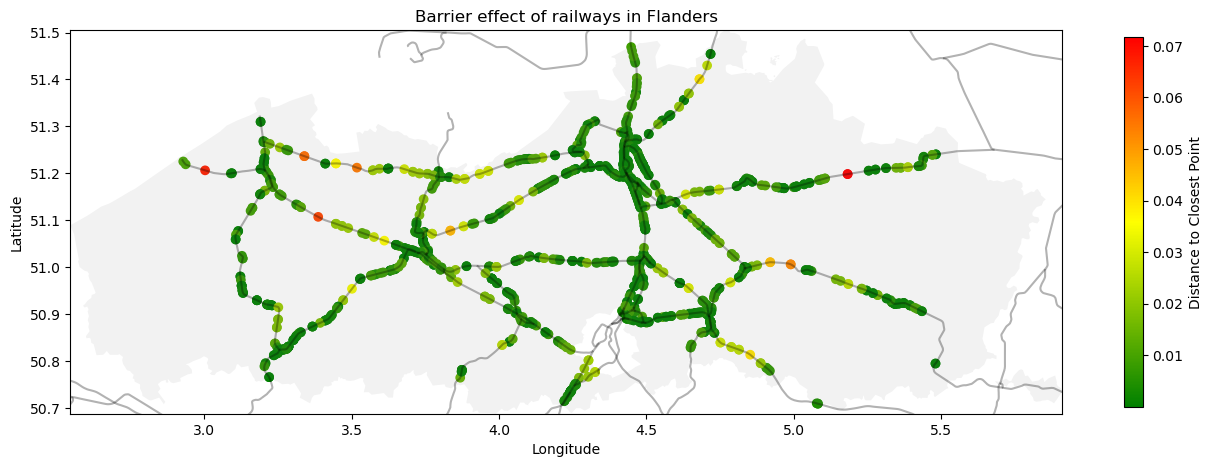

In [179]:

# Define a function to calculate the distance from a line to the closest point in a list of points
def line_min_distance(line, points):
    distances = [line.distance(point) for point in points if point in infrastructure_points]
    distances = [distance for distance in distances if distance != 0 ] # Exclude distance to self
    return min(distances)

# Calculate the distance from each line to the closest point
distances = crossings.geometry.apply(lambda line: line_min_distance(line, points))
 
# Map the distances to a color scale
cmap = LinearSegmentedColormap.from_list('distance', ['green', 'yellow', 'red'])
norm = plt.Normalize(vmin=distances.min(), vmax=distances.max())
colors = [cmap(norm(distance)) for distance in distances]

# Plot the GeoDataFrame using the colors
fig, ax = plt.subplots(figsize=(16,16))
bounds = data_VL.total_bounds
ax = crossings.plot(color=colors, ax=ax)
ax = infrastructure.plot(color="black", alpha=0.3, ax=ax)
# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.3)
cbar.set_label('Distance to Closest Point')
ax.set_title(f"Barrier effect of {infrastructure_name} in Flanders")
ax=data_VL.plot(alpha=0.1,ax=ax,color='gray' )
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3]) 
# Show the plot
plt.show()


C:\Users\Theranet\AppData\Local\Temp\ipykernel_18208\3634515362.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.3)


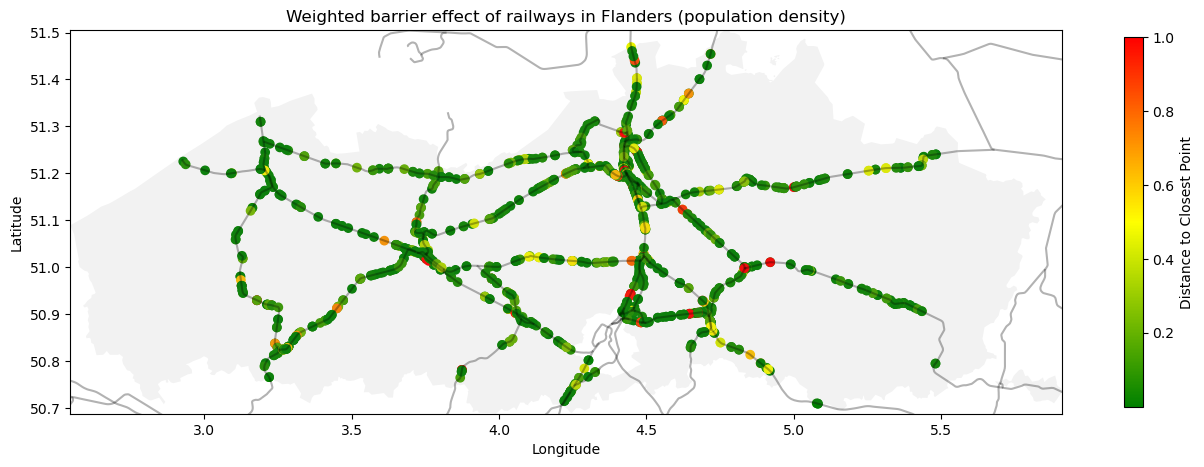

In [180]:

# Read the weighted distances
distances = pd.read_csv('data/weighted_distances.csv')
distances = distances['weighted_distance_normal']

# Map the distances to a color scale
cmap = LinearSegmentedColormap.from_list('distance', ['green', 'yellow', 'red'])
norm = plt.Normalize(vmin=distances.min(), vmax=1)
colors = [cmap(norm(distance)) for distance in distances]

# Plot the GeoDataFrame using the colors
fig, ax = plt.subplots(figsize=(16,16))
bounds = data_VL.total_bounds
ax = crossings.plot(color=colors, ax=ax)
ax = infrastructure.plot(color="black", alpha=0.3, ax=ax)
# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.3)
cbar.set_label('Distance to Closest Point')
ax.set_title(f"Weighted barrier effect of {infrastructure_name} in Flanders (population density)")
ax=data_VL.plot(alpha=0.1,ax=ax, color="gray" )
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3]) 
# Show the plot
plt.show()


## New infrastructure

Let's have a look at railways to be built.

In [ ]:
new_railways=railways[(railways['STAGE_OF_S']=="Planned")&(railways['COUNTRY_CO']=="BE")&(railways['MEASURE_TY']=="New Construction")]

C:\Users\Theranet\AppData\Local\Temp\ipykernel_18208\674267324.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm,shrink=0.3)


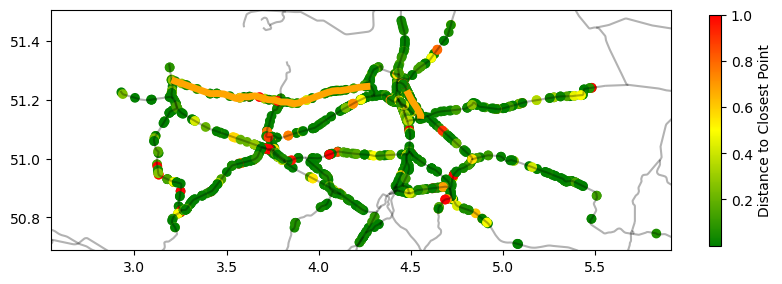

In [181]:

# Plot the GeoDataFrame using the colors
fig, ax = plt.subplots(figsize=(10,10))
bounds = data_VL.total_bounds
ax = rr_crossings.plot(color=colors, ax=ax)
ax = railways.plot(color="black", alpha=0.3, ax=ax)
ax = new_railways.plot(color="orange", ax=ax, linewidth=5)
# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.3)
cbar.set_label('Distance to Closest Point')

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Show the plot
plt.show()